In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Units
| Variable                                 	| Unit of Measurement 	|
|------------------------------------------	|----------------------	|
| $k$, permeability of the liver           	| $m^2$                	|
| $\mu_s$, viscosity of embolizing solution 	| $Pa \cdot s$         	|
| $\mu_o$, viscosity of blood               	| $Pa \cdot s$         	|
| distances                                	| $m$                  	|

| **Symbol**                  | **Description**                                | **Unit**           |
|-----------------------------|------------------------------------------------|--------------------|
| $ k $                     | Permeability of the liver                      | $ \mathrm{m}^2 $ |
| $ \mu_s $                 | Viscosity of embolizing solution               | $ \mathrm{Pa} \cdot \mathrm{s} $ |
| $ \mu_o $                 | Viscosity of blood                             | $ \mathrm{Pa} \cdot \mathrm{s} $ |
| $ \Omega $                | 3D Bulk Domain                                 | Dimensionless      |
| $ \Sigma $                | Cylindrical Vessel                             | Dimensionless      |
| $ \Gamma $                | Lateral Boundary of $ \Sigma $               | Dimensionless      |
| $ \Gamma_0, \Gamma_S $    | Top and Bottom Faces of $ \Sigma $           | Dimensionless      |
| $ \lambda(s) $            | $\mathcal{C}^2$-regular Curve (Centerline)    | $ \mathrm{m} $ (Parameter $ s $) |
| $ s $                     | Arc-length Parameter along $ \lambda $        | $ \mathrm{m} $   |
| $ \Lambda $               | Centerline of $ \Sigma $                      | Dimensionless      |
| $ \mathcal{D}(s) $        | Cross-section of $ \Sigma $                   | $ \mathrm{m}^2 $ |
| $ \partial \mathcal{D}(s) $| Boundary of Cross-section $ \mathcal{D}(s) $  | $ \mathrm{m} $   |
| $ u_{\oplus} $            | Fluid Potential in $ \Omega $ (Exterior)       | $ \mathrm{Pa} $  |
| $ u_{\ominus} $           | Fluid Potential in $ \Lambda $ (Interior)      | $ \mathrm{Pa} $  |
| $ \beta $                 | Coupling Coefficient                            | $ \frac{\mathrm{m}^3}{\mathrm{s} \cdot \mathrm{Pa}} $ |
| $ \kappa $                | Permeability Coefficient                        | $ \frac{\mathrm{m}^2}{\mathrm{s} \cdot \mathrm{Pa}} $ |
| $ g $                     | Source Term                                    | $ \frac{\mathrm{m}}{\mathrm{s}} $ |
| $ \alpha $                | Diffusion Coefficient                           | $ \frac{\mathrm{m}^2}{\mathrm{s} \cdot \mathrm{Pa}} $ |
| $ \Delta $                | Laplacian Operator                              | $ \frac{1}{\mathrm{m}^2} $ |
| $ \delta_{\Lambda} $      | Dirac Measure on $ \Lambda $                  | $ \frac{1}{\mathrm{m}^2} $ |
| $ f $                     | Forcing Term                                    | $ \frac{1}{\mathrm{s}} $ |
| $ \bar{u}_{\oplus} $      | Averaged Fluid Potential in $ \Omega $         | $ \mathrm{Pa} $  |
| $ \bar{u}_{\ominus} $     | Averaged Fluid Potential in $ \Lambda $        | $ \mathrm{Pa} $  |

In [2]:
# @title Install nonstandard libraries
%%capture
!pip install ipywidgets
!pip install vtk
!pip install meshio
!pip install pyvista

import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

In [3]:
WD_PATH = "/content/drive/MyDrive/Research/3D-1D"

import sys, os
sys.path.append(os.path.join(WD_PATH, 'modules'))
import visualizer
import coupler_sensitivity
import meshio
import scipy
import copy
import vtk
import json
import numpy as np
import matplotlib.pyplot as plt
import datetime
import networkx as nx
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
import importlib
from dolfin import *
from vtk.util.numpy_support import vtk_to_numpy
from xii import *
from graphnics import *

/usr/local/lib/python3.10/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [4]:
# @title Define G = serena data graph
%%capture

G = FenicsGraph()
ind = 0
branch_points = {}

for n in range(29):
    file_path = os.path.join(WD_PATH, 'data', 'pv_json1', f'Centerline_{str(n)}.mrk.json')
    f = open(file_path)
    data = json.load(f)
    f.close()

    # get coords + radius at each point
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0]['position'] == val:
            v1 = key
            break

    # add coords and radius to nodes fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]['position']
    pos_v2 = points[1]['position']
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    # add edge to fenics graph
    G.add_edge(v1, v2)

    for i in range(len(points)-2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        # convert coordinates from mm to meters (divide by 1000)
        pos_v1 = [coord / 1000 for coord in points[0]['position']]
        pos_v2 = [coord / 1000 for coord in points[1]['position']]
        pos_v1 = points[i + 1]['position']
        pos_v2 = points[i + 2]['position']
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2, radius=radius[i+1])

    # store last point as a branch point
    ind += len(points)
    branch_points.update({ind-n-1: pos_v2})

In [31]:
# @title Define G = .vtk domain read
%%capture

# function to read .vtk file and extract information
def read_vtk(file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    output = reader.GetOutput()
    G = FenicsGraph()

    for i in range(output.GetNumberOfPoints()):
        point = output.GetPoint(i)
        damage_value = output.GetPointData().GetArray("Damage").GetValue(i)
        radius_value = output.GetPointData().GetArray("Radius").GetValue(i)
        G.add_node(i, pos=tuple(point), radius=radius_value, damage=damage_value)

    for i in range(output.GetNumberOfCells()):
        cell = output.GetCell(i)
        for j in range(cell.GetNumberOfPoints() - 1):
            G.add_edge(cell.GetPointId(j), cell.GetPointId(j + 1))

    return G

file_path = WD_PATH + '/data/vtk/sortedDomain.vtk'
# file_path = WD_PATH + '/oncopigReferenceData/ZPAF23S018/20230531/vesselNetwork_upDated.vtk'
G = read_vtk(file_path)

In [ ]:
# @title Clean graph (only for raw .vtk domain reads)
def cleanup_graph(G):
    G.remove_nodes_from(list(nx.isolates(G)))
    G = nx.convert_node_labels_to_integers(G)

    # Merge close nodes
    positions = nx.get_node_attributes(G, 'pos')
    positions_array = np.array(list(positions.values()))
    tree = cKDTree(positions_array)
    merged_nodes = set()

    for node, pos in positions.items():
        # Find nearby nodes within the threshold distance
        nearby_nodes = tree.query_ball_point(pos, 1.0e-4)

        # Merge with the first nearby node (if any) that hasn't been merged yet
        for other_node in nearby_nodes:
            if other_node != node and other_node not in merged_nodes:
                G = nx.contracted_nodes(G, node, other_node)
                merged_nodes.add(other_node)
                break  # Stop after merging with one node

    # Set zero radii to 0.1
    for node in G.nodes():
        if G.nodes[node]['radius'] == 0:
            G.nodes[node]['radius'] = 0.1

    return G

G = cleanup_graph(G)

In [32]:
import FEMSensitivity
# k = 5.0e-12
# mu_o = 8.9e-4
k = 9.44e-3
mu_o = 4.5e-3
P_cvp = 5 #mmHg
P_in = 100 #mmHg

test = FEMSensitivity.FEMSensitivity(
  G,
  kappa = 1.0,
  alpha = k / mu_o,
  beta = 6.0e4 * (k / mu_o),
  gamma = 0.2,
  del_Omega = P_cvp * 133.322, # Pa
  P_infty = P_in * 133.322 # Pa
)

Averaging over 12326 cells: 100%|██████████| 12326/12326 [00:20<00:00, 612.09it/s]


In [21]:
importlib.reload(visualizer)

<module 'visualizer' from '/content/drive/MyDrive/Research/3D-1D/modules/visualizer.py'>

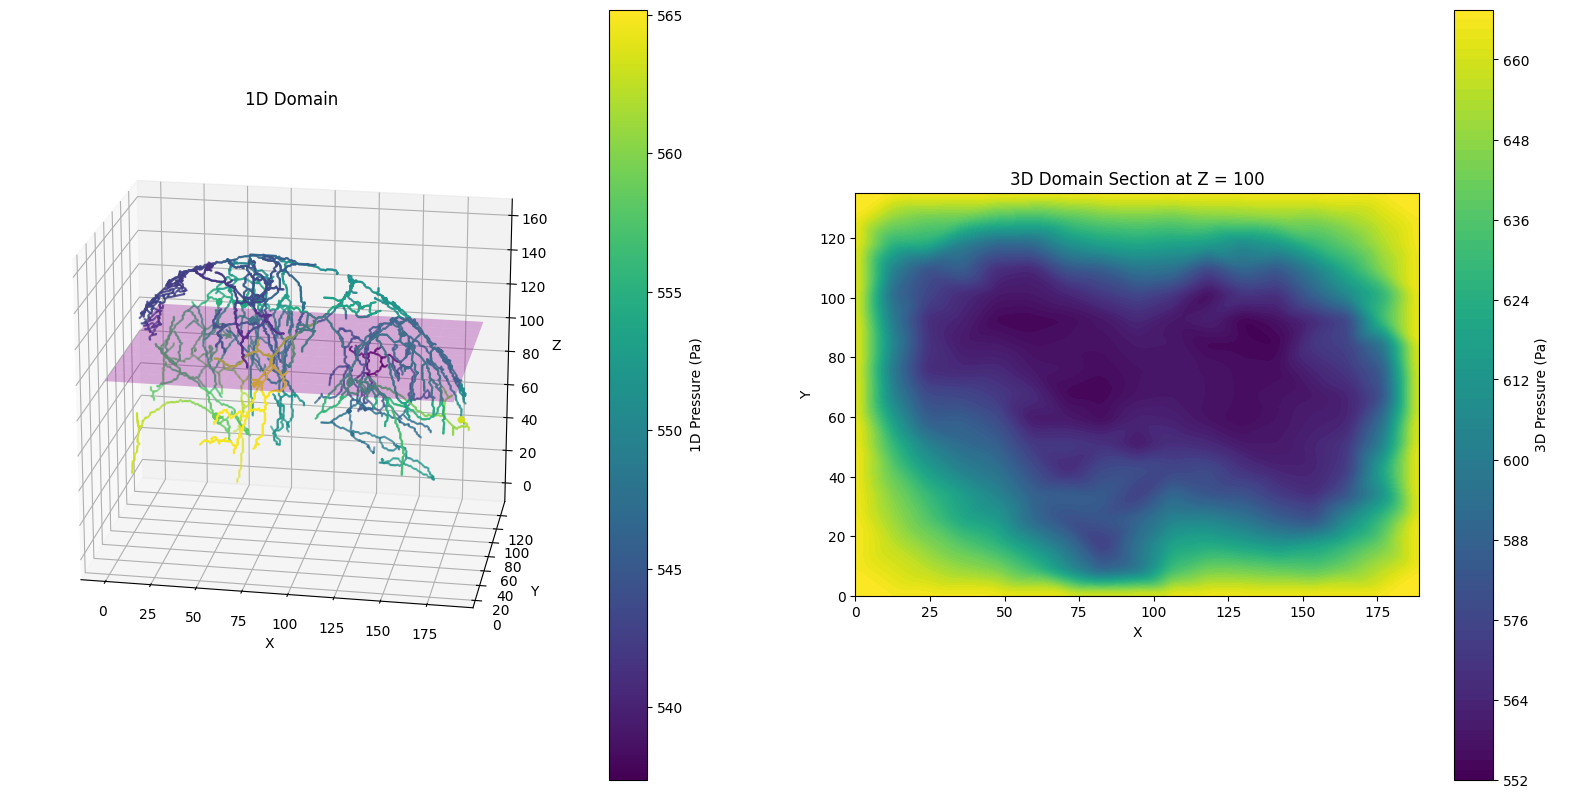

In [37]:
visualizer.visualize(test.Lambda, test.uh1d, mesh3d=test.Omega, sol3d=test.uh3d, elev=20, azim=-80, z_level=100)

In [ ]:
test.save_vtk(os.path.join(WD_PATH, 'perfusion_results', 'test2'))